In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr

Place to get into the correct place for accessing the pickle file

In [2]:
data_dict = pd.read_pickle(r"C:\Users\cae2\Downloads\TSIS_V10_pickles\V10_prod_all_scans_dict_83_84_85_86_87_88_89_90_91_92_93_94_MD_81_to_2000.pickle")
print(f"Imported files with keys {data_dict.keys()}")
df = data_dict[83]
ds = xr.Dataset.from_dataframe(df, sparse=True)

Imported files with keys dict_keys([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])


In [3]:
# create the flat array
channels = ds.channel.to_numpy().ravel()
# iterate through the array and only keep string data
channels = [channel for channel in channels if type(channel) is str]
# convert to a set to get unique values
list(set(channels))

['A']

In [4]:
def unique_string_from_sparse_dataarray(da):
    xs = da.to_numpy().ravel()
    xs = [x for x in xs if type(x) is str]
    xs = list(set(xs))
    if len(xs) == 1:
        return xs[0]
    else:
        return xs

#{x : x**2 for x in range(5)}

In [5]:
dataset_dict = {key: xr.Dataset.from_dataframe(df, sparse=True) for key, df in data_dict.items()}  # exactly is just data_dict

In [6]:
keys = list(dataset_dict.keys())  # list because error, and maybe this disconnects data from dictionary
for key in keys:
    ds = dataset_dict.pop(key)
    new_key = unique_string_from_sparse_dataarray(ds.channel), unique_string_from_sparse_dataarray(ds.detector)
    dataset_dict[new_key] = ds
#dataset_dict

In [7]:
dataset_dict.keys()

dict_keys([('A', 'ESR'), ('A', 'IR'), ('A', 'VIS'), ('A', 'UV'), ('B', 'ESR'), ('B', 'IR'), ('B', 'VIS'), ('B', 'UV'), ('C', 'ESR'), ('C', 'IR'), ('C', 'VIS'), ('C', 'UV')])

How we manipulated the data arrays

In [8]:
# da = ds.sirr[:, 400]  # get the time series of the ESR at the 400th wavelength
# da = da.as_numpy()  # convert to numpy array so not sparse now
# da = da.dropna(dim="scan_time")  # drop elements with no value
# da.interp(scan_time=750)  # interpolate the value to the scan time 750

# # note this all could have been a single line just appending the methods at the end

copying the dataset out of the dictionary and naming that dataset based on channel and imode

In [9]:
ds_uv_a = dataset_dict["A", "UV"]
ds_vis_a = dataset_dict["A", "VIS"]
ds_ir_a = dataset_dict["A", "IR"]
ds_esr_a = dataset_dict["A", "ESR"]

In [10]:
ds_combined_uv = xr.combine_by_coords([ds_uv_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",)
#ds_combined_uv.as_numpy()

ds_combined_vis = xr.combine_by_coords([ds_vis_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",)
#ds_combined_vis.as_numpy()

ds_combined_ir = xr.combine_by_coords([ds_ir_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",)
#ds_combined_ir.as_numpy()

In [11]:
ds_combined_uv["sirr_esr_interp"] = ds_combined_uv.sirr_esr.interpolate_na(dim="scan_time", method="linear")
ds_combined_vis["sirr_esr_interp"] = ds_combined_vis.sirr_esr.interpolate_na(dim="scan_time", method="linear")
ds_combined_ir["sirr_esr_interp"] = ds_combined_ir.sirr_esr.interpolate_na(dim="scan_time", method="linear")
da_ratio_uv = (ds_combined_uv.sirr / ds_combined_uv.sirr_esr_interp)
da_ratio_vis = (ds_combined_vis.sirr / ds_combined_vis.sirr_esr_interp)
da_ratio_ir = (ds_combined_ir.sirr / ds_combined_ir.sirr_esr_interp)
da_ratio_interp_uv = da_ratio_uv.interpolate_na(dim="scan_time", method="linear")
da_ratio_interp_vis = da_ratio_vis.interpolate_na(dim="scan_time", method="linear")
da_ratio_interp_ir = da_ratio_ir.interpolate_na(dim="scan_time", method="linear")

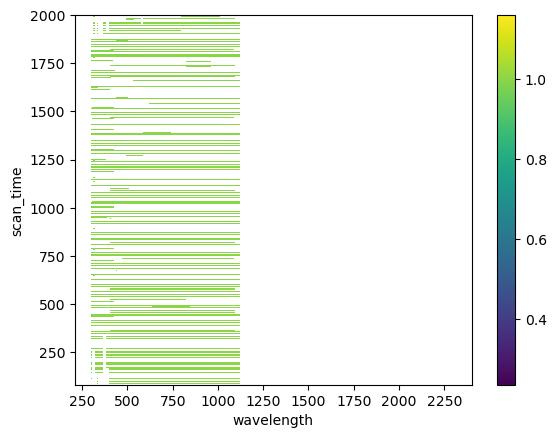

In [13]:
da_ratio_vis.plot()

In [14]:
#Expand color scale on above figure next time

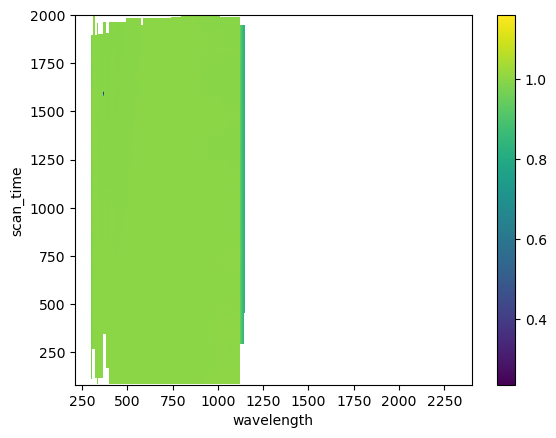

In [15]:
da_ratio_interp_vis.plot()

In [16]:
#Expand color scale on above figure next time

In [18]:
#da_ratio_interp_norm_vis.sel(wavelength = 500, method = "nearest").dropna(dim = "scan_time").plot()

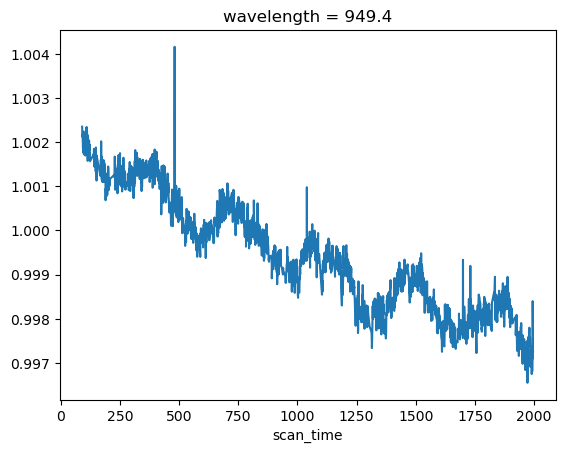

In [19]:
da_ratio_vis.sel(wavelength = 950, method = "nearest").dropna(dim = "scan_time").plot()

In [20]:
#scan_time = ds_combined.scan_time.to_numpy()

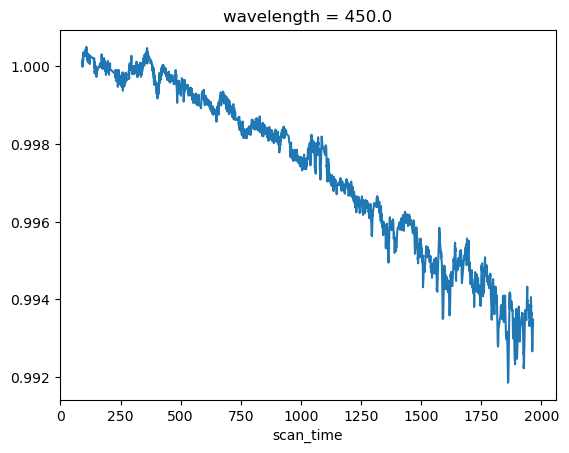

In [21]:
da_ratio_vis.sel(wavelength = 450, method = "nearest").dropna(dim = "scan_time").plot()

For each wavelength in `da_ratio_interp` find the first nonzero measurement and divide all measuments at that wavelength by that measurements

In [12]:
wavelengths_uv = da_ratio_interp_uv.wavelength.to_numpy()
wavelengths_vis = da_ratio_interp_vis.wavelength.to_numpy()
wavelengths_ir = da_ratio_interp_ir.wavelength.to_numpy()

da_ratio_interp_norm_uv = da_ratio_interp_uv.copy()
da_ratio_interp_norm_vis = da_ratio_interp_vis.copy()
da_ratio_interp_norm_ir = da_ratio_interp_ir.copy()

for n in range(len(wavelengths_uv)):
    col_uv = da_ratio_interp_norm_uv[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_uv) > 0:
        first_val = col_uv[0] #finds all first values in row of ratio of sirr
        da_ratio_interp_norm_uv[:,n] = da_ratio_interp_norm_uv[:,n] / first_val #divides row by first value that isnt nan
for n in range(len(wavelengths_vis)):
    col_vis = da_ratio_interp_norm_vis[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_vis) > 0:
        first_val = col_vis[0] 
        da_ratio_interp_norm_vis[:,n] = da_ratio_interp_norm_vis[:,n] / first_val 
for n in range(len(wavelengths_ir)):
    col_ir = da_ratio_interp_norm_ir[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_ir) > 0:
        first_val = col_ir[0]
        da_ratio_interp_norm_ir[:,n] = da_ratio_interp_norm_ir[:,n] / first_val 

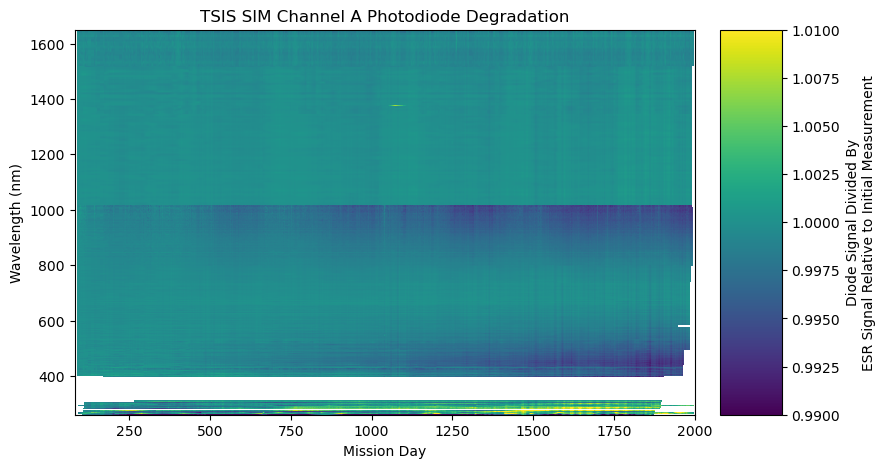

In [23]:
fig, ax=plt.subplots(1) #create new figure with one set of axes
cmap= mpl.cm.viridis #jet
vmin=.990
vmax=1.01
da_ratio_interp_norm_uv.sel(wavelength = slice(260, 395)).plot(x="scan_time", ax=ax, vmin=vmin,vmax =vmax, cmap=cmap, add_colorbar=False)
da_ratio_interp_norm_vis.sel(wavelength = slice(395, 1020)).plot(x="scan_time", ax=ax, vmin=vmin,vmax =vmax, cmap=cmap, add_colorbar=False)
da_ratio_interp_norm_ir.sel(wavelength = slice(1020, 1650)).plot(x="scan_time", ax=ax, vmin=vmin,vmax =vmax, cmap=cmap, add_colorbar=False)
ax.set_xlabel("Mission Day")
ax.set_ylabel("Wavelength (nm)")
ax.set_title("TSIS SIM Channel A Photodiode Degradation")
ax.set_ylim(260,1650)
fig.set_size_inches(8,5)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cax=ax.inset_axes([1.04, 0, .1, 1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              cax=cax, label='Diode Signal Divided By\nESR Signal Relative to Initial Measurement')


Text(0.5, 0, 'Mission Day')

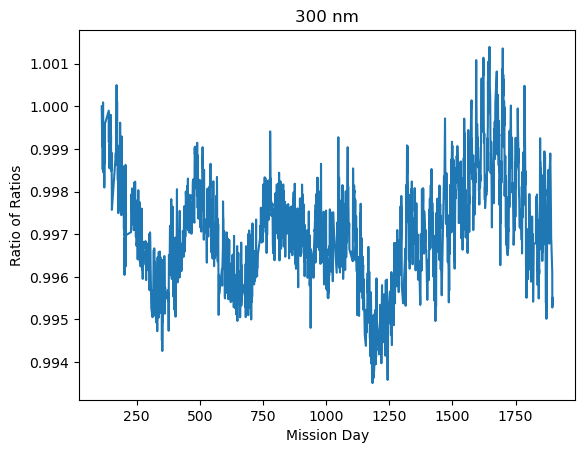

In [38]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_vis.sel(wavelength = 300, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("300 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

In [25]:
fig.savefig("wavelength400.png", bbox_inches="tight")

Text(0.5, 0, 'Mission Day')

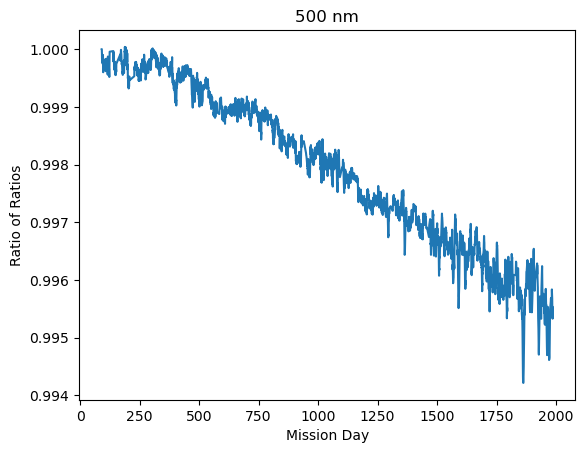

In [39]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_vis.sel(wavelength = 500, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("500 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

Text(0.5, 0, 'Mission Day')

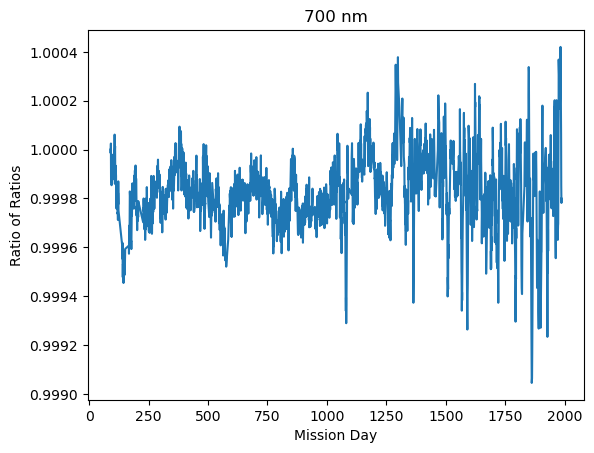

In [40]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_vis.sel(wavelength = 700, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("700 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

Text(0.5, 0, 'Mission Day')

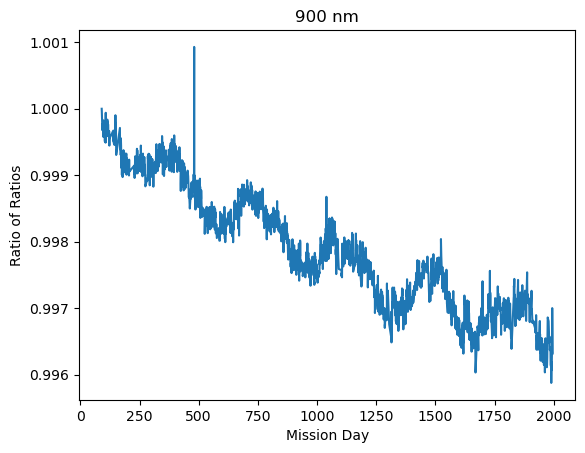

In [41]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_vis.sel(wavelength = 900, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("900 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

Text(0.5, 0, 'Mission Day')

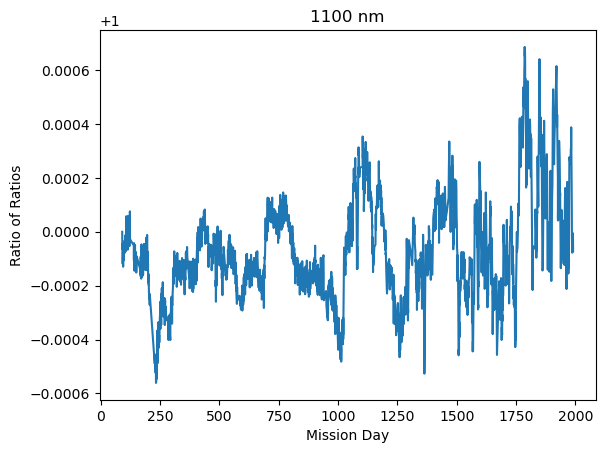

In [43]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_ir.sel(wavelength = 1100, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("1100 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

Text(0.5, 0, 'Mission Day')

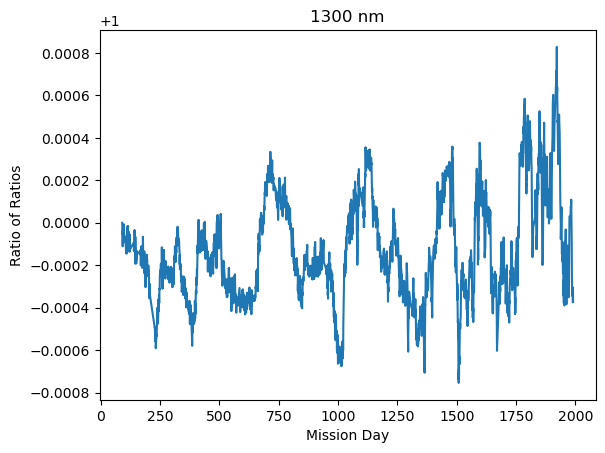

In [37]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_ir.sel(wavelength = 1300, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("1300 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

Text(0.5, 0, 'Mission Day')

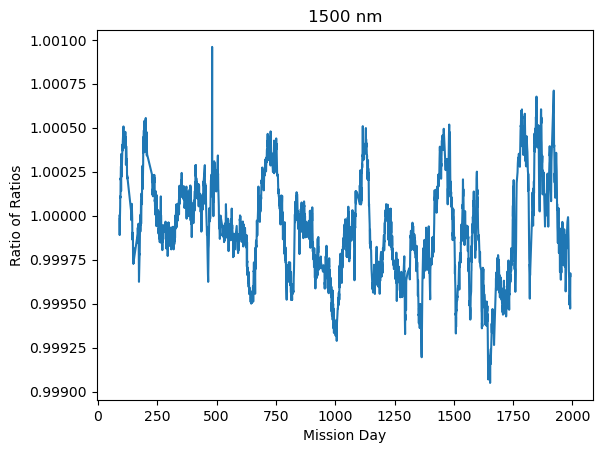

In [36]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_ir.sel(wavelength = 1500, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("1500 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")

Text(0.5, 0, 'Mission Day')

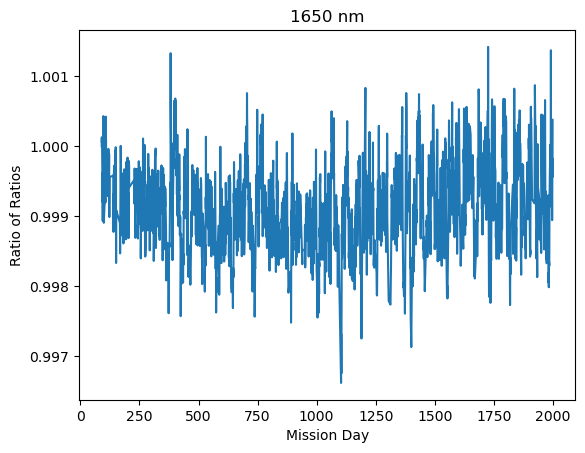

In [33]:
fig, ax=plt.subplots(1)
da_ratio_interp_norm_ir.sel(wavelength = 1650, method = "nearest").dropna(dim = "scan_time").plot()
ax.set_title("1650 nm")
ax.set_ylabel("Ratio of Ratios")
ax.set_xlabel("Mission Day")